In [1]:
import matplotlib.pyplot as plt
import tensorflow_hub as hub
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os
import re

tf.__version__

'1.8.0'

In [2]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
            
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [3]:
# Download and process the dataset files.
def load_datasets_from_folder():
    dataset = "./data/"
    train_df = load_dataset(os.path.join(dataset, "aclImdb", "train"))
    test_df = load_dataset(os.path.join(dataset, "aclImdb", "test"))

    return train_df, test_df

In [4]:
# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = load_datasets_from_folder()
train_df.head()

,sentence,sentiment,polarity
0,"More like psychological analysis of movies, bu...",7,1
1,A Bugs Life is a great film that is not just f...,8,1
2,"This is a bad movie in the traditional sense, ...",7,1
3,"As said before, the visual effects are stunnin...",3,0
4,Needed an excuse to get out of the house while...,2,0


In [5]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

In [6]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

In [7]:
estimator = tf.estimator.DNNClassifier(
    hidden_units=[500, 100],
    feature_columns=[embedded_text_feature_column],
    n_classes=2,
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))

In [8]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 5 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=1000)

In [9]:
train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)

print ("Training set accuracy: {accuracy}".format(**train_eval_result))
print ("Test set accuracy: {accuracy}".format(**test_eval_result))

Training set accuracy: 0.8018400073051453
Test set accuracy: 0.7934399843215942


Text(33,0.5,'True')

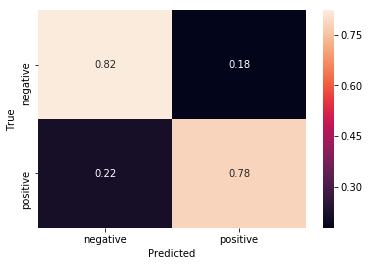

In [10]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = ["negative", "positive"]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    cm = tf.confusion_matrix(train_df["polarity"], 
                             get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")